In [9]:
import psycopg
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
import time
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import pandas as pd

from collections import Counter


mapping_original = {
    "172.16.65.50": "Surveillance emetteur",
    "192.168.1.2": "Temps reel interactif",
    "192.168.1.3": "Temps reel interactif",
    "200.57.7.196": "Temps reel interactif",
    "193.63.53.155": "Live Broadcast",
    "193.63.53.156": "Transfert",

    "11.10.10.10": "Surveillance emetteur",
    "11.10.10.9": "Surveillance emetteur",
    "11.10.10.8": "Surveillance emetteur",
    "10.10.10.12": "Surveillance receveur",
    "10.10.10.13": "Surveillance receveur",
    "10.10.10.14": "Surveillance receveur",
    
    "192.168.10.3": "Surveillance emetteur",
    "192.168.10.6": "Surveillance emetteur",
    "192.168.10.12": "Surveillance receveur",
    "192.168.10.2": "Speaker",
    "192.168.10.5": "Speaker",
    "192.168.10.50": "Speaker",
    "192.168.10.4": "Iot non streaming",

    "192.168.1.106": "Surveillance emetteur",
    "192.168.1.159": "Iot non streaming",
    "192.168.1.240": "Speaker",
    "192.168.1.166": "Surveillance emetteur",
    "192.168.1.241": "Surveillance emetteur",
    "192.168.1.236": "Iot non streaming",
    "192.168.1.156": "Iot non streaming",
    "192.168.1.165": "Surveillance emetteur",
    "192.168.1.152": "Iot non streaming",
    "192.168.1.143": "Surveillance emetteur",
    "192.168.1.221": "Surveillance emetteur",
    "192.168.1.230": "Surveillance emetteur",
    "192.168.1.120": "Speaker (simple)",
    "192.168.1.196": "Iot non streaming",
    "192.168.1.168": "Iot non streaming",
    "192.168.1.112": "Iot non streaming",
    "192.168.1.118": "Iot non streaming",
    "192.168.1.223": "Iot non streaming",
    "192.168.1.163": "Iot non streaming",
    "192.168.1.216": "Surveillance emetteur",
    "192.168.1.249": "Surveillance emetteur",
    "192.168.1.193": "Surveillance mouvement",

    "192.168.137.10": "Iot non streaming",
    "192.168.137.11": "Iot non streaming",
    "192.168.137.12": "Iot non streaming",
    "192.168.137.13": "Iot non streaming",

    "198.18.134.11": "industry non streaming",
    "198.18.134.12": "industry non streaming",
    "198.18.134.15": "Personal",

	"192.168.1.248": "Surveillance emetteur",
	"192.168.1.111": "Surveillance emetteur",
	"192.168.1.218": "Iot non streaming",
	"192.168.1.172": "Iot non streaming",
	"192.168.1.186": "Iot non streaming",
	"192.168.1.179": "Personal",
	"192.168.1.175": "Speaker",
	"192.168.1.189": "Surveillance emetteur",
    "192.168.1.205": "Iot non streaming",
	"192.168.1.228": "Surveillance emetteur",
}

mapping = {
    "172.16.65.50": "Surveillance",
    "11.10.10.10": "Surveillance",
    "11.10.10.9": "Surveillance",
    "11.10.10.8": "Surveillance", #test
    "192.168.10.3": "Surveillance",
    "192.168.10.6": "Surveillance", #test
    "192.168.1.106": "Surveillance",
    "192.168.1.166": "Surveillance",
    "192.168.1.241": "Surveillance", #test
    "192.168.1.164": "Surveillance",
    "192.168.1.143": "Surveillance",
    "192.168.1.221": "Surveillance", #test
    "192.168.1.230": "Surveillance",
    "192.168.1.216": "Surveillance",
    "192.168.1.249": "Surveillance", #test
    "192.168.1.193": "Surveillance",
	"192.168.1.248": "Surveillance", #---
	"192.168.1.111": "Surveillance", #test
	"192.168.1.189": "Surveillance",
	"192.168.1.228": "Surveillance",

    # Surveillance receveur
    "10.10.10.12": "Surveillance",
    "10.10.10.13": "Surveillance",
    "10.10.10.14": "Surveillance", #test
    "192.168.10.12": "Surveillance",

    # Speaker
    "192.168.10.2": "Surveillance",
    "192.168.10.5": "Surveillance",
    "192.168.10.50": "Surveillance", #test
    "192.168.1.240": "Surveillance",
	"192.168.1.175": "Surveillance", #test ---
    "192.168.1.120": "Not Streaming",

    # Temps reel interactif
    "192.168.1.2": "Surveillance", #test
    "192.168.1.3": "Surveillance",
    "200.57.7.196": "Surveillance",

    # Iot non streaming
    "192.168.10.4": "Not Streaming",
    "192.168.1.159": "Not Streaming",
    "192.168.1.236": "Not Streaming",
    "192.168.1.156": "Not Streaming", #test
    "192.168.1.152": "Not Streaming", #test
    "192.168.1.196": "Not Streaming",
    "192.168.1.168": "Not Streaming", #test
    "192.168.1.112": "Not Streaming",
    "192.168.1.118": "Not Streaming", #test
    "192.168.1.223": "Not Streaming", #test
    "192.168.1.163": "Not Streaming",
    "198.18.134.11": "Not Streaming",
    "198.18.134.120": "Not Streaming", #test
    "198.18.134.150": "Not Streaming",
	"192.168.1.218": "Not Streaming", #---
	"192.168.1.172": "Not Streaming", #test
	"192.168.1.186": "Not Streaming",
    "192.168.1.205": "Not Streaming", #test

    # Media
    "192.168.137.10": "Not Streaming",
    "192.168.137.11": "Not Streaming",
    "192.168.137.12": "Not Streaming", #test
    "192.168.137.13": "Not Streaming",

	"192.168.1.179": "Not Streaming", #---

    #"193.63.53.155": "Live Broadcast",
    #"193.63.53.156": "Transfert",
}


val_ips = ["11.10.10.8", "192.168.10.6", "192.168.1.241", "192.168.1.221", "192.168.1.249", "192.168.1.111",
    "10.10.10.14", "192.168.10.50", "192.168.1.175", "192.168.1.2", "192.168.1.156", "192.168.1.152", "192.168.1.168", "192.168.1.118",
    "192.168.1.223", "198.18.134.120", "192.168.1.172", "192.168.1.205", "192.168.137.12"]

train_ips = ['192.168.1.166', '10.10.10.12', '192.168.1.193', '192.168.1.163', '192.168.1.230',
            '192.168.10.3', '192.168.137.10', '192.168.1.143', '192.168.1.240', '192.168.137.11',
            '172.16.65.50', '192.168.1.159', '192.168.10.2', '10.10.10.13', '192.168.1.196', '192.168.1.236',
            '198.18.134.11', '192.168.10.5', '192.168.1.106', '192.168.1.216', '192.168.10.4', '11.10.10.9', '200.57.7.196',
            '192.168.137.13', '11.10.10.10', '192.168.10.12', '192.168.1.3', '192.168.1.120', '198.18.134.150', '192.168.1.112',
            '192.168.1.164', '192.168.1.248', '192.168.1.189', '192.168.1.228', '192.168.1.218', '192.168.1.186']



In [10]:
# Connexion à la base
conn = psycopg.connect(
    dbname="sniff",
    user="cialson",
    password="3913",
    host="localhost",
    port="5432"
)
cur = conn.cursor()


# Liste des tables à prendre en compte pour l'entraînement
tables = [
    "network_trame_camera1",
    "network_trame_camera2",
    "network_trame_camera3",
    "network_trame_camera4",
    "network_trame_camera5",
    "network_trame_camera6",
    "network_trame_camera7",
    "network_trame_camera8",
    "network_trame_camera9",
    "network_trame_camera10",
    "network_trame_camera11",
    "network_trame_camera12",
    "network_trame_camera13",
    "network_trame_camera14",
    "network_trame_camera15",
    "network_trame_camera16", #---
    "network_trame_camera17",
    "network_trame_camera18",
    "network_trame_camera19",
    "network_trame_consumer1",
    "network_trame_consumer2",
    "network_trame_consumer3",
    "network_trame_consumer6",
    "network_trame_speaker1",
    "network_trame_speaker2",
    "network_trame_speaker3",
    "network_trame_speaker4",
    "network_trame_speaker5",
    "network_trame_speaker6", #---
    "network_trame_rtp_rtsp",
    "network_trame_rtp_sip",
    "network_trame_rtp_sip2",
    "network_trame_rtp_sip3",
    "iot_non_stream1",
    "iot_non_stream2",
    "iot_non_stream3",
    "iot_non_stream4",
    "iot_non_stream5",
    "iot_non_stream6",
    "iot_non_stream7",
    "iot_non_stream8",
    "iot_non_stream9",
    "iot_non_stream10",
    "iot_non_stream11",
    "iot_non_stream12", #---
    "iot_non_stream13",
    "iot_non_stream14",
    "iot_non_stream15",
    "network_trame_media1",
    "network_trame_media2",
    "network_trame_media3",
    "network_trame_media4",
    "network_trame_industry1",
    "network_trame_industry2",
    "network_trame_personal1",
    "network_trame_personal2", #---
    #"network_trame_stream",
    #"network_trame_transfert"
]

def is_lan(ip):
    # Détermine si une IP est dans un LAN (privée)
    if ip.startswith("10.") or ip.startswith("192.168.") or ip.startswith("172.16.") or ip.startswith("172.17.") or ip.startswith("172.18.") or ip.startswith("172.19.") or ip.startswith("172.20.") or ip.startswith("172.21.") or ip.startswith("172.22.") or ip.startswith("172.23.") or ip.startswith("172.24.") or ip.startswith("172.25.") or ip.startswith("172.26.") or ip.startswith("172.27.") or ip.startswith("172.28.") or ip.startswith("172.29.") or ip.startswith("172.30.") or ip.startswith("172.31."):
        return 1
    return -1

# Regroupement par ip
records = []
ip_packets = {}
last_time_per_ip = {}
direction_map = {"in": -1, "out": 1}
protocol_map = {"TCP": -1, "UDP": 1}

for table in tables:
    query = "SELECT time, ip_src, ip_dst, size, prot_transp, port_src, port_dst, direction FROM " + table + ";"

    cur.execute(query)

    rows = cur.fetchall()

    ip_key = "None"

    for pkt_time, ip_src, ip_dst, pkt_size, pkt_prot, port_src, port_dst, direction in rows:
        if ip_src in mapping and ip_dst not in mapping:
            ip_key = ip_src
            break
        elif ip_src not in mapping and ip_dst in mapping:
            ip_key = ip_dst
            break

    if ip_key != "None":
        for pkt_time, ip_src, ip_dst, pkt_size, pkt_prot, port_src, port_dst, direction in rows:

            # Calcul delta_t propre à chaque IP source
            last_time = last_time_per_ip.get(ip_key)
            delta_t = 0.0 if last_time is None else pkt_time - last_time
            last_time_per_ip[ip_key] = pkt_time

            # Filtrage des paquets avec delta_t trop long
            if delta_t > 700.0:
                continue

            pkt = {
                "size": float(pkt_size),
                "delta_t": float(delta_t),
                "prot_transp": protocol_map.get(pkt_prot),
                "port_src": int(port_src),
                "port_dst": int(port_dst),
                "direction": direction_map.get(direction),
                "ip_src_lan": is_lan(ip_src),
                "ip_dst_lan": is_lan(ip_dst)
            }

            # Ajout dans le regroupement
            if ip_key not in ip_packets:
                ip_packets[ip_key] = []
            ip_packets[ip_key].append(pkt)
    else:
        print("non")


cur.close()
conn.close()


window_size = 200  # ou la valeur de seq_len
stride_train = 150      # recouvrement 25% pour train
stride_val = window_size  # pas de recouvrement pour val
max_windows_per_mac = 100  # à ajuster selon le dataset

# Conversion finale vers la structure attendue
for ip, pkts in ip_packets.items():
    n = len(pkts)
    if n < 2*window_size:
        continue  # on ignore les séquences trop courtes
    windows = []
    if ip in train_ips:
        for start in range(0, n - window_size + 1, stride_train):
            window = pkts[start:start+window_size]
            windows.append({"ip": ip, "packets": window})
    elif ip in val_ips:
        for start in range(0, n - window_size + 1, stride_val):
            window = pkts[start:start+window_size]
            windows.append({"ip": ip, "packets": window})

    # Limite le nombre de fenêtres par appareil
    if len(windows) > max_windows_per_mac:
        windows = windows[:max_windows_per_mac]
    records.extend(windows)

# Extraire les labels réellement présents dans les données
labels_in_data = [mapping[r["ip"]] for r in records if r["ip"] in mapping]

# Apprendre le LabelEncoder uniquement sur ces labels
label_encoder = LabelEncoder().fit(list(set(labels_in_data)))

print("Classes réellement apprises :", label_encoder.classes_)

print(Counter([mapping[r["ip"]] for r in records if r["ip"] in mapping]))

print(f"{len(records)} séquences extraites depuis la base PostgreSQL.")

Classes réellement apprises : ['Not Streaming' 'Surveillance']
Counter({'Surveillance': 2189, 'Not Streaming': 2100})
4289 séquences extraites depuis la base PostgreSQL.


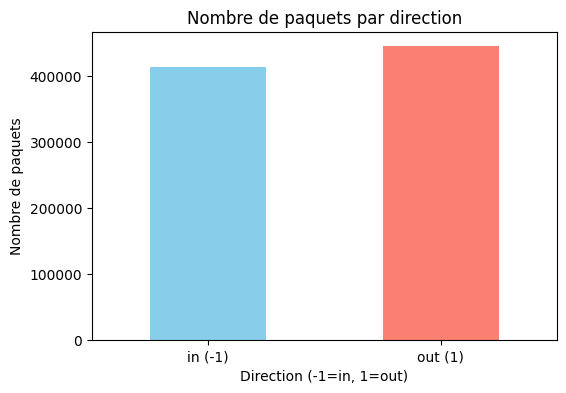

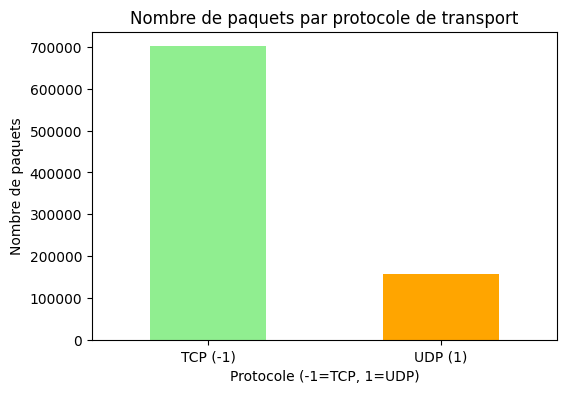

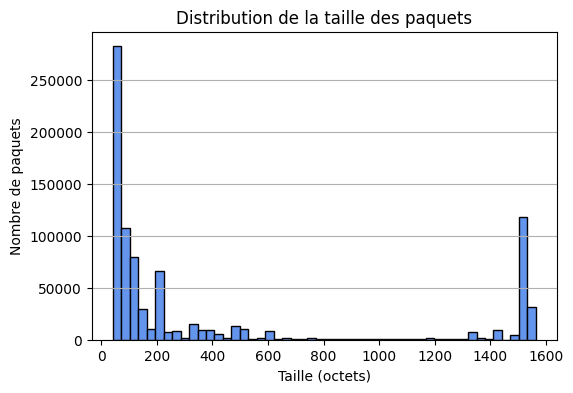

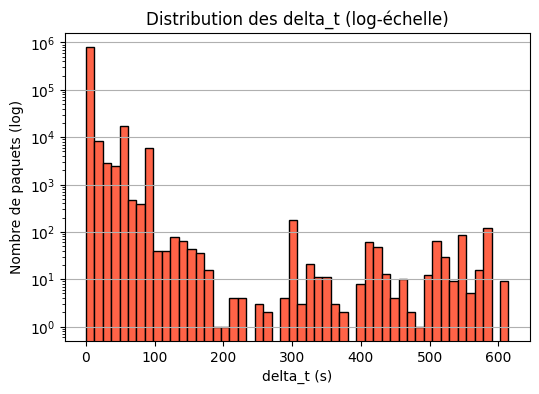

In [11]:
# Analyse exploratoire

# Rassembler toutes les features dans un DataFrame pour analyse
all_packets = []
for r in records:
    for p in r["packets"]:
        all_packets.append({
            "size": p["size"],
            "delta_t": p["delta_t"],
            "direction": p["direction"],  # -1 = in, 1 = out
            "prot_transp": p["prot_transp"]  # -1 = TCP, 1 = UDP
        })

df = pd.DataFrame(all_packets)

# Graphe 1 : Nombre de paquets par direction (barres)
plt.figure(figsize=(6,4))
df['direction'].value_counts().sort_index().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title("Nombre de paquets par direction")
plt.xlabel("Direction (-1=in, 1=out)")
plt.ylabel("Nombre de paquets")
plt.xticks([0,1], ["in (-1)", "out (1)"], rotation=0)
plt.show()

# Graphe 2 : Nombre de paquets par protocole de transport (barres)
plt.figure(figsize=(6,4))
df['prot_transp'].value_counts().sort_index().plot(kind='bar', color=['lightgreen', 'orange'])
plt.title("Nombre de paquets par protocole de transport")
plt.xlabel("Protocole (-1=TCP, 1=UDP)")
plt.ylabel("Nombre de paquets")
plt.xticks([0,1], ["TCP (-1)", "UDP (1)"], rotation=0)
plt.show()

# Graphe 3 : Histogramme simple de la taille des paquets
plt.figure(figsize=(6,4))
df['size'].plot(kind='hist', bins=50, color='cornflowerblue', edgecolor='black')
plt.title("Distribution de la taille des paquets")
plt.xlabel("Taille (octets)")
plt.ylabel("Nombre de paquets")
plt.grid(axis='y')
plt.show()

# Graphe 4 : Histogramme simple des delta_t (log-échelle pour mieux voir)
plt.figure(figsize=(6,4))
plt.hist(df['delta_t'], bins=50, color='tomato', edgecolor='black', log=True)
plt.title("Distribution des delta_t (log-échelle)")
plt.xlabel("delta_t (s)")
plt.ylabel("Nombre de paquets (log)")
plt.grid(axis='y')
plt.show()

In [12]:
# === Bloc 5 : Dataset PyTorch avec commentaires détaillés ===


class NetworkSequenceDataset(Dataset):
    """
    Cette classe transforme les trames réseau extraites de PostgreSQL
    en un format compatible avec PyTorch (tenseurs numériques fixes).

    Chaque élément du dataset correspond à un appareil (IP),
    représenté par une séquence temporelle de paquets réseau.
    """

    def __init__(self, records, label_map, seq_len=200):
        # records : liste de dictionnaires {mac: str, packets: [ {...}, {...} ]}
        # label_map : mapping IP → type d’appareil
        # seq_len : longueur maximale d’une séquence (nombre de paquets utilisés)

        self.records = records
        self.seq_len = seq_len
        self.label_map = label_map

        # --- Normalisation des valeurs numériques ---
        sizes = [p["size"] for r in records for p in r["packets"]]
        deltas = [p["delta_t"] for r in records for p in r["packets"]]
        port_srcs = [p["port_src"] for r in records for p in r["packets"]]
        port_dsts = [p["port_dst"] for r in records for p in r["packets"]]
        self.size_mean, self.size_std = np.mean(sizes), np.std(sizes) + 1e-6
        self.dt_mean, self.dt_std = np.mean(deltas), np.std(deltas) + 1e-6
        self.port_src_mean, self.port_src_std = np.mean(port_srcs), np.std(port_srcs) + 1e-6
        self.port_dst_mean, self.port_dst_std = np.mean(port_dsts), np.std(port_dsts) + 1e-6

        to_save = {
            "size_mean": self.size_mean,
            "size_std": self.size_std,
            "dt_mean": self.dt_mean,
            "dt_std": self.dt_std,
            "port_src_mean": self.port_src_mean,
            "port_src_std": self.port_src_std,
            "port_dst_mean": self.port_dst_mean,
            "port_dst_std": self.port_dst_std,
            "label_encoder": label_encoder
        }

        with open("preprocessing_params.pkl", "wb") as f:
            pickle.dump(to_save, f)

    def __len__(self):
        """Nombre total d'appareils (séquences)"""
        return len(self.records)

    def __getitem__(self, idx):
        """Renvoie un échantillon (une séquence d’un appareil)"""
        r = self.records[idx]
        pkts = r["packets"]
        seq_len = min(self.seq_len, len(pkts))  # tronque si trop long

        # Features numériques : size, delta_t, port_src, port_dst, ip_src_lan, ip_dst_lan, direction, prot_transp
        num_feats = np.zeros((self.seq_len, 8), dtype=np.float32)

        for i in range(seq_len):
            p = pkts[i]
            num_feats[i, 0] = (p.get("size", 0.0) - self.size_mean) / self.size_std
            num_feats[i, 1] = (p.get("delta_t", 0.0) - self.dt_mean) / self.dt_std
            num_feats[i, 2] = (p.get("port_src", 0) - self.port_src_mean) / self.port_src_std
            num_feats[i, 3] = (p.get("port_dst", 0) - self.port_dst_mean) / self.port_dst_std
            num_feats[i, 4] = p.get("ip_src_lan", 0)
            num_feats[i, 5] = p.get("ip_dst_lan", 0)
            num_feats[i, 6] = p.get("direction", 0)
            num_feats[i, 7] = p.get("prot_transp", 0)

        # --- Récupération du label (type d’appareil) ---
        label = self.label_map.get(r["ip"], "Unknown")
        label_id = label_encoder.transform([label])[0]

        # --- Retourne un dictionnaire PyTorch ---
        return {
            "num_feats": torch.tensor(num_feats, dtype=torch.float32),
            "label": torch.tensor(label_id, dtype=torch.long)
        }


In [ ]:
# === Bloc 6 : Définition du modèle CNN + LSTM avec commentaires détaillés ===

class CNNLSTMModel(nn.Module):
    """
    Modèle hybride CNN + LSTM pour classer le type d’appareil
    à partir de ses séquences de paquets réseau.
    """

    def __init__(self, n_num_feats=8, cnn_channels=64, lstm_hidden=128, n_classes=6):
        super().__init__()

        # Dimension finale d’un paquet
        self.feat_dim = n_num_feats

        # --- Étape 1 : bloc CNN pour extraire les motifs locaux ---
        # La convolution 1D glisse sur la séquence de paquets (axe temporel)
        self.conv1 = nn.Conv1d(self.feat_dim, cnn_channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU()        # fonction d'activation
        self.pool = nn.MaxPool1d(2)  # réduction de la taille temporelle
        self.dropout_cnn = nn.Dropout(0.3)   # Dropout après CNN

        # --- Étape 2 : bloc LSTM pour capturer la dynamique temporelle ---
        # LSTM = mémoire à long terme pour séquences temporelles
        self.lstm = nn.LSTM(cnn_channels, lstm_hidden, batch_first=True)
        self.dropout_lstm = nn.Dropout(0.3)  # Dropout après LSTM

        # --- Étape 3 : couche de sortie ---
        # Classification finale selon le type d’appareil
        self.fc = nn.Linear(lstm_hidden, n_classes)
        self.dropout = nn.Dropout(0.4)  # régularisation (évite l’overfitting)

    def forward(self, num_feats):
        """
        Décrit le cheminement des données dans le réseau.
        """

        # --- Étape 1 : features numériques
        x = num_feats  # (B, T, feat_dim)

        # --- Étape 2 : Passage CNN ---
        # PyTorch attend les features en 2e dimension pour Conv1D → on permute
        x = x.permute(0, 2, 1)  # (B, F, T)
        x = self.relu(self.conv1(x))  # extraction de motifs
        x = self.pool(x)              # réduction temporelle
        x = x.permute(0, 2, 1)        # retour (B, T', C)

        # --- Étape 3 : Passage LSTM ---
        # Le LSTM parcourt la séquence et garde la mémoire du contexte
        _, (h_n, _) = self.lstm(x)

        # --- Étape 4 : Sortie ---
        # h_n[-1] = état caché du dernier pas de temps (résumé global)
        out = self.dropout_lstm(h_n[-1])
        out = self.dropout(out)
        out = self.fc(out)  # classification finale
        return out


In [34]:
# === Bloc 7 : Entraînement CNN + LSTM avec commentaires ===

def train_cnn_lstm(records, label_map):
    """
    Entraîne le modèle CNN + LSTM sur les séquences réseau extraites.
    """
    # Création du dataset PyTorch
    dataset = NetworkSequenceDataset(records, label_map, seq_len=200)
    n_classes = len(label_encoder.classes_)
    '''
    # Division en ensembles d'entraînement / validation
    train_idx, val_idx = train_test_split(range(len(dataset)), test_size=0.2, random_state=42)
    train_loader = DataLoader(torch.utils.data.Subset(dataset, train_idx), batch_size=16, shuffle=True)
    val_loader = DataLoader(torch.utils.data.Subset(dataset, val_idx), batch_size=16, shuffle=False)
    '''
    # --- Split par IP pour éviter le data leakage ---
    ips = list(set([r["ip"] for r in records]))
    #train_ips, val_ips = train_test_split(ips, test_size=0.5, random_state=42)

    train_records = [r for r in records if r["ip"] in train_ips]
    val_records = [r for r in records if r["ip"] in val_ips]

    train_dataset = NetworkSequenceDataset(train_records, mapping, seq_len=200)
    val_dataset = NetworkSequenceDataset(val_records, mapping, seq_len=200)
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
    print("Train IPs :", train_ips)
    print("Val IPs :", val_ips)
    print("Train classes :", Counter([mapping[r["ip"]] for r in train_records]))
    print("Val classes :", Counter([mapping[r["ip"]] for r in val_records]))

    # Initialisation du modèle
    model = CNNLSTMModel(
        n_num_feats=8,  # ou la taille réelle de num_feats
        cnn_channels=64,
        lstm_hidden=128,  
        n_classes=n_classes
    )

    # Détection du périphérique (CPU ou GPU)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Optimiseur et fonction de coût
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()

    # Historique pour suivi visuel
    history = {"loss": [], "val_acc": [], "val_f1": []}

    # --- Boucle d'entraînement ---
    for epoch in range(1, 51):  # 20 époques
        model.train()
        total_loss = 0

        # Entraînement sur le jeu d'entraînement
        for batch in train_loader:
            num = batch["num_feats"].to(device)
            labels = batch["label"].to(device)

            # Étape 1 : passage avant
            optimizer.zero_grad()
            outputs = model(num)

            # Étape 2 : calcul de la perte
            loss = criterion(outputs, labels)

            # Étape 3 : rétropropagation
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * num.size(0)

        # --- Évaluation sur validation ---
        model.eval()
        preds, trues = [], []
        with torch.no_grad():
            for batch in val_loader:
                num = batch["num_feats"].to(device)
                labels = batch["label"].to(device)

                outputs = model(num)
                pred = outputs.argmax(1)
                preds.extend(pred.cpu().numpy())
                trues.extend(labels.cpu().numpy())

        # Calcul des métriques
        acc = accuracy_score(trues, preds)
        f1 = f1_score(trues, preds, average="macro")
        loss_epoch = total_loss / len(train_loader.dataset)

        # Sauvegarde des résultats
        history["loss"].append(loss_epoch)
        history["val_acc"].append(acc)
        history["val_f1"].append(f1)

        print(f"Epoch {epoch:02d}: Loss={loss_epoch:.4f}, Val_Acc={acc:.3f}, F1={f1:.3f}")

    return model, history


Train IPs : ['192.168.1.166', '10.10.10.12', '192.168.1.193', '192.168.1.163', '192.168.1.230', '192.168.10.3', '192.168.137.10', '192.168.1.143', '192.168.1.240', '192.168.137.11', '172.16.65.50', '192.168.1.159', '192.168.10.2', '10.10.10.13', '192.168.1.196', '192.168.1.236', '198.18.134.11', '192.168.10.5', '192.168.1.106', '192.168.1.216', '192.168.10.4', '11.10.10.9', '200.57.7.196', '192.168.137.13', '11.10.10.10', '192.168.10.12', '192.168.1.3', '192.168.1.120', '198.18.134.150', '192.168.1.112', '192.168.1.164', '192.168.1.248', '192.168.1.189', '192.168.1.228', '192.168.1.218', '192.168.1.186']
Val IPs : ['11.10.10.8', '192.168.10.6', '192.168.1.241', '192.168.1.221', '192.168.1.249', '192.168.1.111', '10.10.10.14', '192.168.10.50', '192.168.1.175', '192.168.1.2', '192.168.1.156', '192.168.1.152', '192.168.1.168', '192.168.1.118', '192.168.1.223', '198.18.134.120', '192.168.1.172', '192.168.1.205', '192.168.137.12']
Train classes : Counter({'Surveillance': 1421, 'Not Streamin

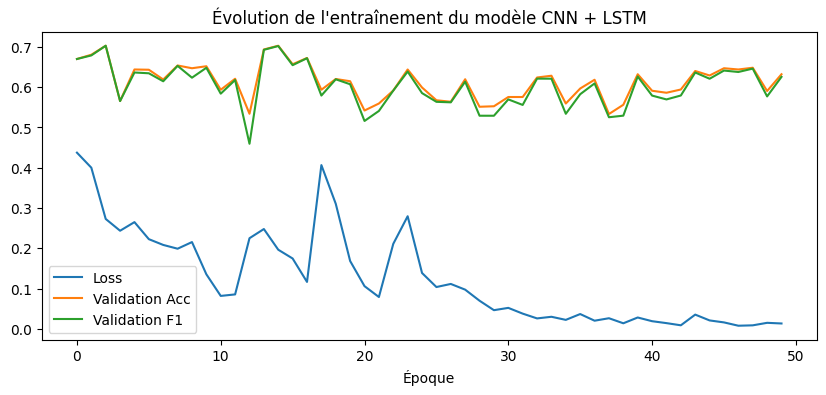

In [37]:
# === Bloc 8 : Entraînement et visualisation ===

model, history = train_cnn_lstm(records, mapping)

# Sauvegarde du modèle entraîné
torch.save(model.state_dict(), "cnn_lstm_model_stream_Nstream.pth")

# Visualisation de l'évolution de l'entraînement
plt.figure(figsize=(10,4)) 
plt.plot(history["loss"], label="Loss")
plt.plot(history["val_acc"], label="Validation Acc")
plt.plot(history["val_f1"], label="Validation F1")
plt.legend()

plt.title("Évolution de l'entraînement du modèle CNN + LSTM")
plt.xlabel("Époque")
plt.show()
